<a href="https://colab.research.google.com/github/VarunGor/ML/blob/master/Bike_Sharing_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Bike Sharing Demand Prediction

---

# VARUN GOR

<h2>Predict use of a city bikeshare (Linear Regression)</h2>

We have hourly rental data spanning two years. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. 

We must predict ***the total count of bikes rented during each hour*** covered by the test set, using only information available prior to the rental period.

**Data Fields** 


1.   datetime - hourly date + timestamp
2.   season - 1 = spring, 2 = summer, 3 = fall, 4 = winter 
3.   holiday - whether the day is considered a holiday
4.   workingday - whether the day is neither a weekend nor holiday
5.   weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy  
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
6.  temp - temperature in Celsius
7. atemp - "feels like" temperature in Celsius
8. humidity - relative humidity
9. windspeed - wind speed
10. casual - number of non-registered user rentals initiated
11. registered - number of registered user rentals initiated
12. count - number of total rentals

In [0]:
import pandas as pd
import numpy as np

## Loading the Data

In [0]:
url = 'https://raw.githubusercontent.com/VarunGor/Dataset/master/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [154]:
print('Data Rows : ', len(bikes))
bikes.head(5)

Data Rows :  10886


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [0]:
# "count" is a method, so it's best to name that column something else
bikes.rename(columns={'count':'total'}, inplace = True)



In [156]:
bikes.describe()


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## Exploratory Data Analysis (EDA)

In [0]:
import seaborn as sb
import matplotlib.pyplot as plt

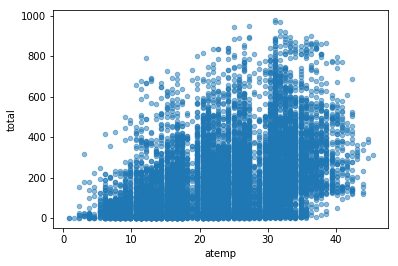

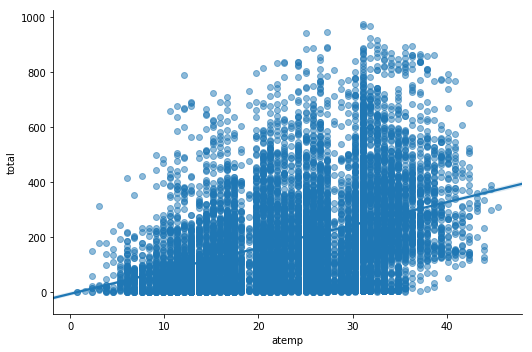

In [158]:
# Pandas scatter plot
bikes.plot(kind='scatter', x='atemp', y='total', alpha=0.5)

sb.lmplot(x='atemp', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.5})

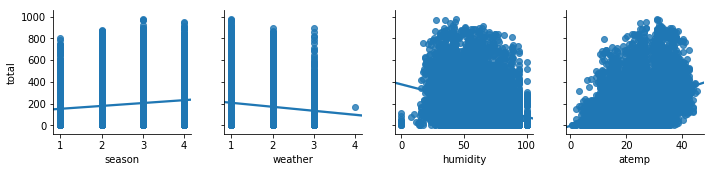

In [159]:
# explore more features
features = ['season', 'weather', 'humidity', 'atemp']
sb.pairplot(bikes, x_vars=features, y_vars='total', kind='reg')

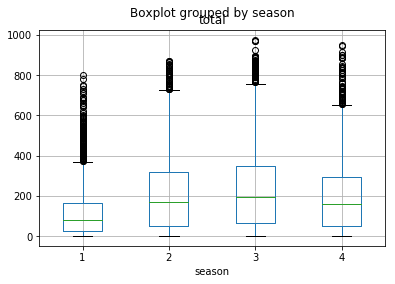

In [160]:
# box plot of rentals, grouped by season
bikes.boxplot(column='total', by='season')

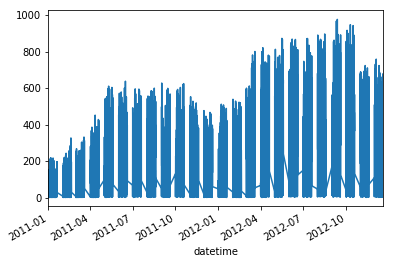

In [161]:
# line plot of rentals
bikes.total.plot()

There are more rentals in the winter than the spring, but only because the system is experiencing overall growth and the winter months happen to come after the spring months.


## Building a simple linear regression model

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
# create input X(Independent Variable(s)) and output y(Dependent Variable)

feature_cols = ['atemp']

X = bikes[feature_cols]
y = bikes.total


In [164]:
# instantiate of linearregression and fit

linReg = LinearRegression()
linReg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [165]:
# print the coefficients

print (linReg.intercept_)
print (linReg.coef_)

-5.5114213685680795
[8.33163614]


## Creating benchmark with NULL RMSE

Null RMSE is the RMSE that could be achieved by **always predicting the mean response value**.  

It is a benchmark against which we can measure the performance of regression model.

In [0]:
from sklearn import metrics

In [167]:
# create a NumPy array with the same shape as y
y_null = np.zeros_like(y, dtype=float)

# fill the array with mean value of y
y_null.fill(y.mean())
y_null

array([191.57413191, 191.57413191, 191.57413191, ..., 191.57413191,
       191.57413191, 191.57413191])

In [168]:
# compute null RMSE
np.sqrt(metrics.mean_squared_error(y, y_null))

181.1361335742659

## Cross Validation

In [0]:
from sklearn.model_selection import train_test_split 


In [0]:
# function that accepts a list of features and returns RMSE

def train_test_rmse(feature_cols):
    X = bikes[feature_cols]
    y = bikes.total
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [171]:
# compare different sets of features

print (train_test_rmse(['atemp', 'season', 'weather']))
print (train_test_rmse(['atemp', 'season', 'humidity']))
print (train_test_rmse(['atemp', 'season', 'weather', 'humidity']))


164.68183108597634
155.62881073938377
155.6648324509633


## Feature Creation

**Creating dummy variables for categorical features**

As we have seen during Cross validation ***atemp, season and humidity*** gives similer results with ***atemp, season, weather and humidity***. 

we can infer that weather has no significant role in this dataset.

**So only categorical varible we left with in this dataset is Season.**

In [0]:
# create dummy variables
season_dummies = pd.get_dummies(bikes.season, prefix='season')

# drop the first column
season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)

# print 8 random rows
#season_dummies.sample(n=8, random_state=2)

In [0]:
# concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
bikes = pd.concat([bikes, season_dummies], axis=1)

# print 5 random rows
#bikes.sample(n=5, random_state=1)

In [174]:
# compare original season variable with dummy variables
print (train_test_rmse(['temp', 'season', 'humidity']))
print (train_test_rmse(['temp', 'season_2', 'season_3', 'season_4', 'humidity']))


155.59818936691417
154.33394593635998


## Feature engineering

In [0]:
# hour as a numeric feature
bikes['hour'] = bikes.index.hour

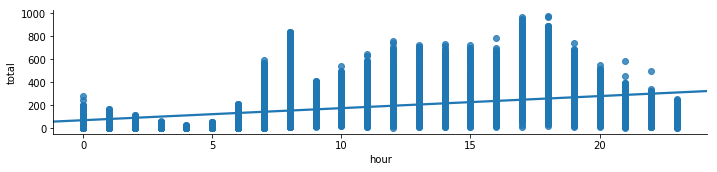

In [176]:
# line plot of hour rentals
sb.pairplot(bikes, x_vars='hour', y_vars='total', kind='reg', aspect=4)


In [0]:
# peak time as a categorical feature
bikes['peak_time'] = ( ((bikes.hour > 6) & (bikes.hour < 10)) | ((bikes.hour > 11) & (bikes.hour < 20)) ).astype(int)

In [0]:
# hour as a categorical feature
hour_dummies = pd.get_dummies(bikes.hour, prefix='hour')
hour_dummies.drop(hour_dummies.columns[0], axis=1, inplace=True)

bikes = pd.concat([bikes, hour_dummies], axis=1)

In [179]:
print (train_test_rmse(['peak_time']))
print (train_test_rmse(bikes.columns[bikes.columns.str.startswith('hour_')]))
print (train_test_rmse(['atemp', 'season_2', 'season_3', 'season_4', 'humidity', 'peak_time']))


148.28019825354465
128.3112050281119
132.6083179336352


In [180]:
input_feature = ['atemp','season_2','season_3', 'season_4', 'humidity', 'weather']
input_feature.extend(bikes.columns[bikes.columns.str.startswith('hour_')])

#input_feature
print (train_test_rmse(input_feature))

111.61586449097454
